In [2]:
import re
from tqdm.notebook import tqdm

from IPython.display import display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

from covid_flu import config, utils, time_series, plotting,models

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Introduction 

The goal of this exploration is to build recurrent neural networks (RNN) for forecasting flu rates across states and times. Our main goal is not find a state of the art model which can predict the next week with the highest accuracy. Instead, ultimately we want to build an accurate model for multi-step predictions. For instance, we argue that knowing in advance the projected rates for the next 5 weeks is important in this application, since it gives authorities the time needed to plan ahead projected spikes in flu activity. 

Given our goal, we are more interested in comparing different models in terms of how well they capture the patterns and less about hypermarameter tuning for finding the optimal parameters resulting in the lowest RMSE. Hence, in this analysis we are not focusing on finding the optimal architecture or hyperparameters but rather exploring different RNN models.

We will start from simple LSTM models and progressively move to more complex RNN structures. Specifically we explore:

- Simple LSTM for one step predictions.
- Simple LSTM with vector output for multi-step predictions
- Seq2Seq encoder-decoder architectures for multi-step predictions
- Seq2Seq with attention for multi-step predictions

## Loading clean data and scaling


In [3]:
df_flu = pd.read_csv(config.processed / 'flu_ground_truth_imputed.csv')
df_flu.head(5)

,time,wili,state
0,2010-40,2.06514,Texas
1,2010-41,2.09394,Texas
2,2010-42,2.10072,Texas
3,2010-43,2.20655,Texas
4,2010-44,2.36381,Texas


In [4]:
X = df_flu['wili'].values
groups = df_flu['state'].values
sc = StandardScaler()
X_scaled = sc.fit_transform(X.reshape(-1,1)).flatten()

## Simple LSTM for one step prediction

In this section we explore simple LSTM models which are provided a history of H weeks (e.g. 25 weeks) to predict the flu rate in next week.

In [48]:
HISTORY_SIZE = 25
TARGET_SIZE = 1

In [49]:
ds_train, ds_val, ds_test, data_dict = time_series.prepare_data(X_scaled, 
                                                                groups,
                                                                history_size=HISTORY_SIZE, 
                                                                target_size=TARGET_SIZE, 
                                                                test_size = 0.2,
                                                                batch_size = 256
                                                               )

In [50]:
#create arrays for testing later
X_test = data_dict['X_test']
y_test = data_dict['y_test']
states_test = data_dict['states_test']

In [5]:
def make_simple_lstm(history_length=25, target_length=1, num_lstm_layers=2, hidden_size=32, pre_output_dense_size=16):
    #builds simple lstm with variable length of hidden layers and 
    #one dense layer before the output layer
    
    simple_lstm = tf.keras.models.Sequential()
    for i in range(num_lstm_layers):
        if i==0:
            simple_lstm.add(layers.LSTM(hidden_size, activation='relu', input_shape=(history_length,1), return_sequences=True))
        elif i==num_lstm_layers-1:
            simple_lstm.add(layers.LSTM(hidden_size, activation='relu'))
        else:
            simple_lstm.add(layers.LSTM(hidden_size, activation='relu', return_sequences=True))
    if pre_output_dense_size!=None:
        simple_lstm.add(layers.Dense(pre_output_dense_size, activation='relu'))
    simple_lstm.add(layers.Dense(target_length))
    simple_lstm.compile(optimizer='adam', loss='mse')
    return simple_lstm

In [10]:
simple_lstm = make_simple_lstm(num_lstm_layers=3,hidden_size=32,pre_output_dense_size=32)

In [11]:
simple_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 25, 32)            4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, 25, 32)            8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 22,081
Trainable params: 22,081
Non-trainable params: 0
_________________________________________________________________


In [12]:
history_simplelstm = simple_lstm.fit(ds_train, epochs=10, validation_data=ds_val)


Epoch 1/10
68/68 [==============================] - 12s 177ms/step - loss: 0.6206 - val_loss: 0.0000e+00
Epoch 2/10
68/68 [==============================] - 6s 86ms/step - loss: 0.3069 - val_loss: 0.2442
Epoch 3/10
68/68 [==============================] - 6s 83ms/step - loss: 0.1583 - val_loss: 0.1275
Epoch 4/10
68/68 [==============================] - 6s 85ms/step - loss: 0.1121 - val_loss: 0.1112
Epoch 5/10
68/68 [==============================] - 6s 84ms/step - loss: 0.1050 - val_loss: 0.1174
Epoch 6/10
68/68 [==============================] - 6s 82ms/step - loss: 0.1021 - val_loss: 0.1043
Epoch 7/10
68/68 [==============================] - 6s 86ms/step - loss: 0.1053 - val_loss: 0.1127
Epoch 8/10
68/68 [==============================] - 6s 82ms/step - loss: 0.1029 - val_loss: 0.1150
Epoch 9/10
68/68 [==============================] - 6s 83ms/step - loss: 0.1036 - val_loss: 0.1098
Epoch 10/10
68/68 [==============================] - 6s 86ms/step - loss: 0.1049 - val_loss: 0.1058


In [42]:
def calculate_rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)

In [43]:
def calc_rmse_model(y_true, x, model, history_length, scaler=None):
    #calculates unscaled RMSE for a model on a test set
    preds = model.predict(x)
    if scaler!=None:
        y_true = scaler.inverse_transform(y_true.flatten())
        preds = scaler.inverse_transform(preds)
    return calculate_rmse(y_true, preds)

In [40]:
calc_rmse_model(y_test, X_test, simple_lstm, HISTORY_SIZE, sc)

0.7560938564938511

In [51]:
results_dict = {}
results_dict['simple_lstm_25_weeks'] = calc_rmse_model(y_test, X_test, simple_lstm, HISTORY_SIZE, sc)

A simple LSTM predicts next week's unscaled WILI rate, given past 25 weeks with **test set RMSE 0.756**.

In [6]:
def plot_preds_for_state(X_test, y_test, states_test, model, history_length, state, scaler=None):
    #plot of the predictions for a given state
    
    preds = model.predict(X_test[states_test==state])
    y = y_test[states_test==state].flatten()
    if scaler!=None:
        y = scaler.inverse_transform(y_test[states_test==state].flatten())
        preds = scaler.inverse_transform(preds)
    
    print(f"RMSE = {calculate_rmse(y, preds)}")
    
    plt.figure(figsize=(10,8))
    plt.plot(y, 'b-', label='True')
    plt.plot(preds, 'r-', label='Predicted')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('WILI')
    plt.title(f'True vs Predicted for {state}')
    plt.show()

In [7]:
def plot_test_preds_for_all_states(X_test, y_test, states_test, model, history_length, suptitle, scaler=None):
    preds = model.predict(X_test)
    y = y_test.flatten()
    if scaler!=None:
        y = scaler.inverse_transform(y_test.flatten())
        preds = scaler.inverse_transform(preds)
    
    all_states = np.unique(states_test)
    fig, ax = plt.subplots(10, 5, figsize = (60,30))
    fig.suptitle(suptitle, y=0.99, fontsize=25)
    fig.subplots_adjust(top=0.94)
    
    for i, ax in enumerate(fig.axes):
        state = all_states[i]
        y_state = y[states_test==state]
        preds_state = preds[states_test==state]
        ax.plot(y_state, 'b-', label='True')
        ax.plot(preds_state, 'r-', label='Predicted')
        ax.legend()
        ax.set_xlabel('Time')
        ax.set_ylabel('WILI')
        ax.set_title(f'True vs Predicted for {state}')
    
    plt.show()
    

Below we are plotting the predictions of the LSTM for a given state on a test set.

RMSE = 0.7489911261345026


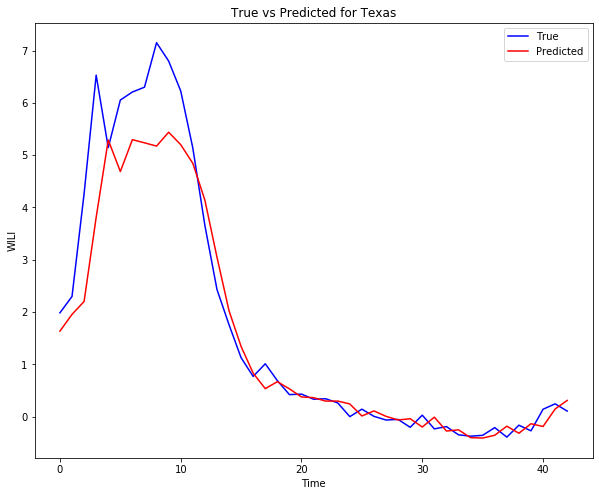

In [20]:
plot_preds_for_state(X_test, y_test, states_test, simple_lstm, HISTORY_SIZE, 'Texas')

Below we are plotting the predictions of the LSTM for the full time series of a given state (concatenation of train, validation and test set, last 20% of the time series is unseen).

In [23]:
X_all = np.concatenate((data_dict['X_train'],data_dict['X_val'], data_dict['X_test']))
y_all = np.concatenate((data_dict['y_train'],data_dict['y_val'], data_dict['y_test']))
states_all = np.concatenate((data_dict['states_train'],data_dict['states_val'], data_dict['states_test']))

RMSE = 0.44502727628494526


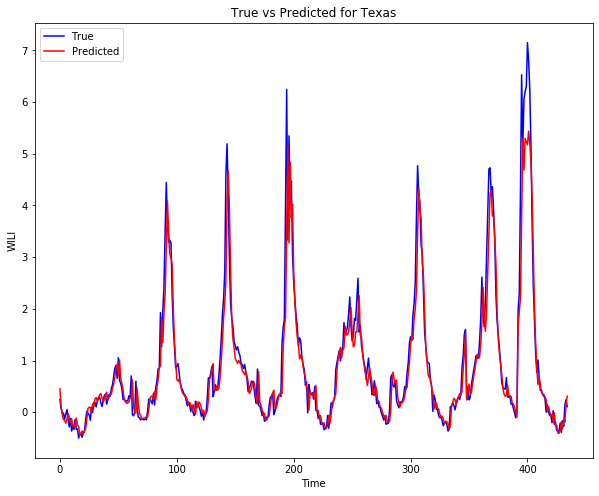

In [24]:
plot_preds_for_state(X_all, y_all, states_all, simple_lstm, HISTORY_SIZE, 'Texas')


### Does history size play a role in predictions?

Below we fitting different simple LSTM models for varying history sizes. 

#### History of 10 weeks

In [53]:
HISTORY_SIZE = 10
TARGET_SIZE = 1

In [54]:
ds_train, ds_val, ds_test, data_dict = time_series.prepare_data(X_scaled, 
                                                                groups,
                                                                history_size=HISTORY_SIZE, 
                                                                target_size=TARGET_SIZE, 
                                                                test_size = 0.2,
                                                                batch_size = 256
                                                               )

In [55]:
#create arrays for testing later
X_test = data_dict['X_test']
y_test = data_dict['y_test']
states_test = data_dict['states_test']

In [31]:
simple_lstm10 = make_simple_lstm(history_length=HISTORY_SIZE, target_length=TARGET_SIZE,
                                 num_lstm_layers=3,hidden_size=32,pre_output_dense_size=32)


In [32]:
simple_lstm10.fit(ds_train, epochs=10, validation_data=ds_val)


Epoch 1/10
71/71 [==============================] - 6s 91ms/step - loss: 0.6146 - val_loss: 0.0000e+00
Epoch 2/10
71/71 [==============================] - 3s 36ms/step - loss: 0.2161 - val_loss: 0.1407
Epoch 3/10
71/71 [==============================] - 3s 36ms/step - loss: 0.1210 - val_loss: 0.1107
Epoch 4/10
71/71 [==============================] - 3s 40ms/step - loss: 0.1123 - val_loss: 0.1145
Epoch 5/10
71/71 [==============================] - 3s 36ms/step - loss: 0.1086 - val_loss: 0.1113
Epoch 6/10
71/71 [==============================] - 3s 36ms/step - loss: 0.1109 - val_loss: 0.1094
Epoch 7/10
71/71 [==============================] - 3s 36ms/step - loss: 0.1096 - val_loss: 0.1045
Epoch 8/10
71/71 [==============================] - 3s 36ms/step - loss: 0.1077 - val_loss: 0.1115
Epoch 9/10
71/71 [==============================] - 3s 36ms/step - loss: 0.1073 - val_loss: 0.1112
Epoch 10/10
71/71 [==============================] - 3s 39ms/step - loss: 0.1097 - val_loss: 0.1051


In [45]:
calc_rmse_model(y_test, X_test, simple_lstm10, HISTORY_SIZE, sc)

0.7687849998191966

In [56]:
results_dict['simple_lstm_10_weeks'] = calc_rmse_model(y_test, X_test, simple_lstm10, HISTORY_SIZE, sc)

In [57]:
results_dict

{'simple_lstm_25_weeks': 0.7560938564938511,
 'simple_lstm_10_weeks': 0.7687849998191966}

#### History of 50 weeks

In [59]:
HISTORY_SIZE = 50
TARGET_SIZE = 1

ds_train, ds_val, ds_test, data_dict = time_series.prepare_data(X_scaled, 
                                                                groups,
                                                                history_size=HISTORY_SIZE, 
                                                                target_size=TARGET_SIZE, 
                                                                test_size = 0.2,
                                                                batch_size = 256
                                                               )

#create arrays for testing later
X_test = data_dict['X_test']
y_test = data_dict['y_test']
states_test = data_dict['states_test']

In [60]:
simple_lstm50 = make_simple_lstm(history_length=HISTORY_SIZE, target_length=TARGET_SIZE,
                                 num_lstm_layers=3,hidden_size=32,pre_output_dense_size=32)


In [61]:
simple_lstm50.fit(ds_train, epochs=10, validation_data=ds_val)


Epoch 1/10
65/65 [==============================] - 14s 222ms/step - loss: 0.6582 - val_loss: 0.0000e+00
Epoch 2/10
65/65 [==============================] - 11s 163ms/step - loss: 0.3228 - val_loss: 0.2687
Epoch 3/10
65/65 [==============================] - 11s 164ms/step - loss: 0.1740 - val_loss: 0.1737
Epoch 4/10
65/65 [==============================] - 10s 159ms/step - loss: 0.1193 - val_loss: 0.1060
Epoch 5/10
65/65 [==============================] - 11s 163ms/step - loss: 0.1177 - val_loss: 0.1317
Epoch 6/10
65/65 [==============================] - 11s 163ms/step - loss: 0.1113 - val_loss: 0.1167
Epoch 7/10
65/65 [==============================] - 10s 159ms/step - loss: 0.1065 - val_loss: 0.1047
Epoch 8/10
65/65 [==============================] - 11s 162ms/step - loss: 0.1047 - val_loss: 0.0992
Epoch 9/10
65/65 [==============================] - 11s 162ms/step - loss: 0.1050 - val_loss: 0.1129
Epoch 10/10
65/65 [==============================] - 11s 163ms/step - loss: 0.1050 - va

In [62]:
print(calc_rmse_model(y_test, X_test, simple_lstm50, HISTORY_SIZE, sc))
results_dict['simple_lstm_50_weeks'] = calc_rmse_model(y_test, X_test, simple_lstm50, HISTORY_SIZE, sc)
results_dict

0.6156131281906476


{'simple_lstm_25_weeks': 0.7560938564938511,
 'simple_lstm_10_weeks': 0.7687849998191966,
 'simple_lstm_50_weeks': 0.6156131281906476}

A longer history of 50 weeks works well for predicting the next week resulting in significantly lower RMSE across states.

RMSE = 0.2237444096931305


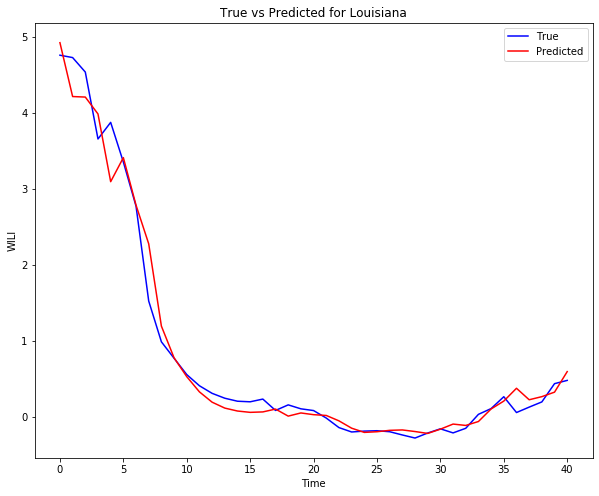

In [66]:
plot_preds_for_state(X_test, y_test, states_test, simple_lstm50, HISTORY_SIZE, 'Louisiana')

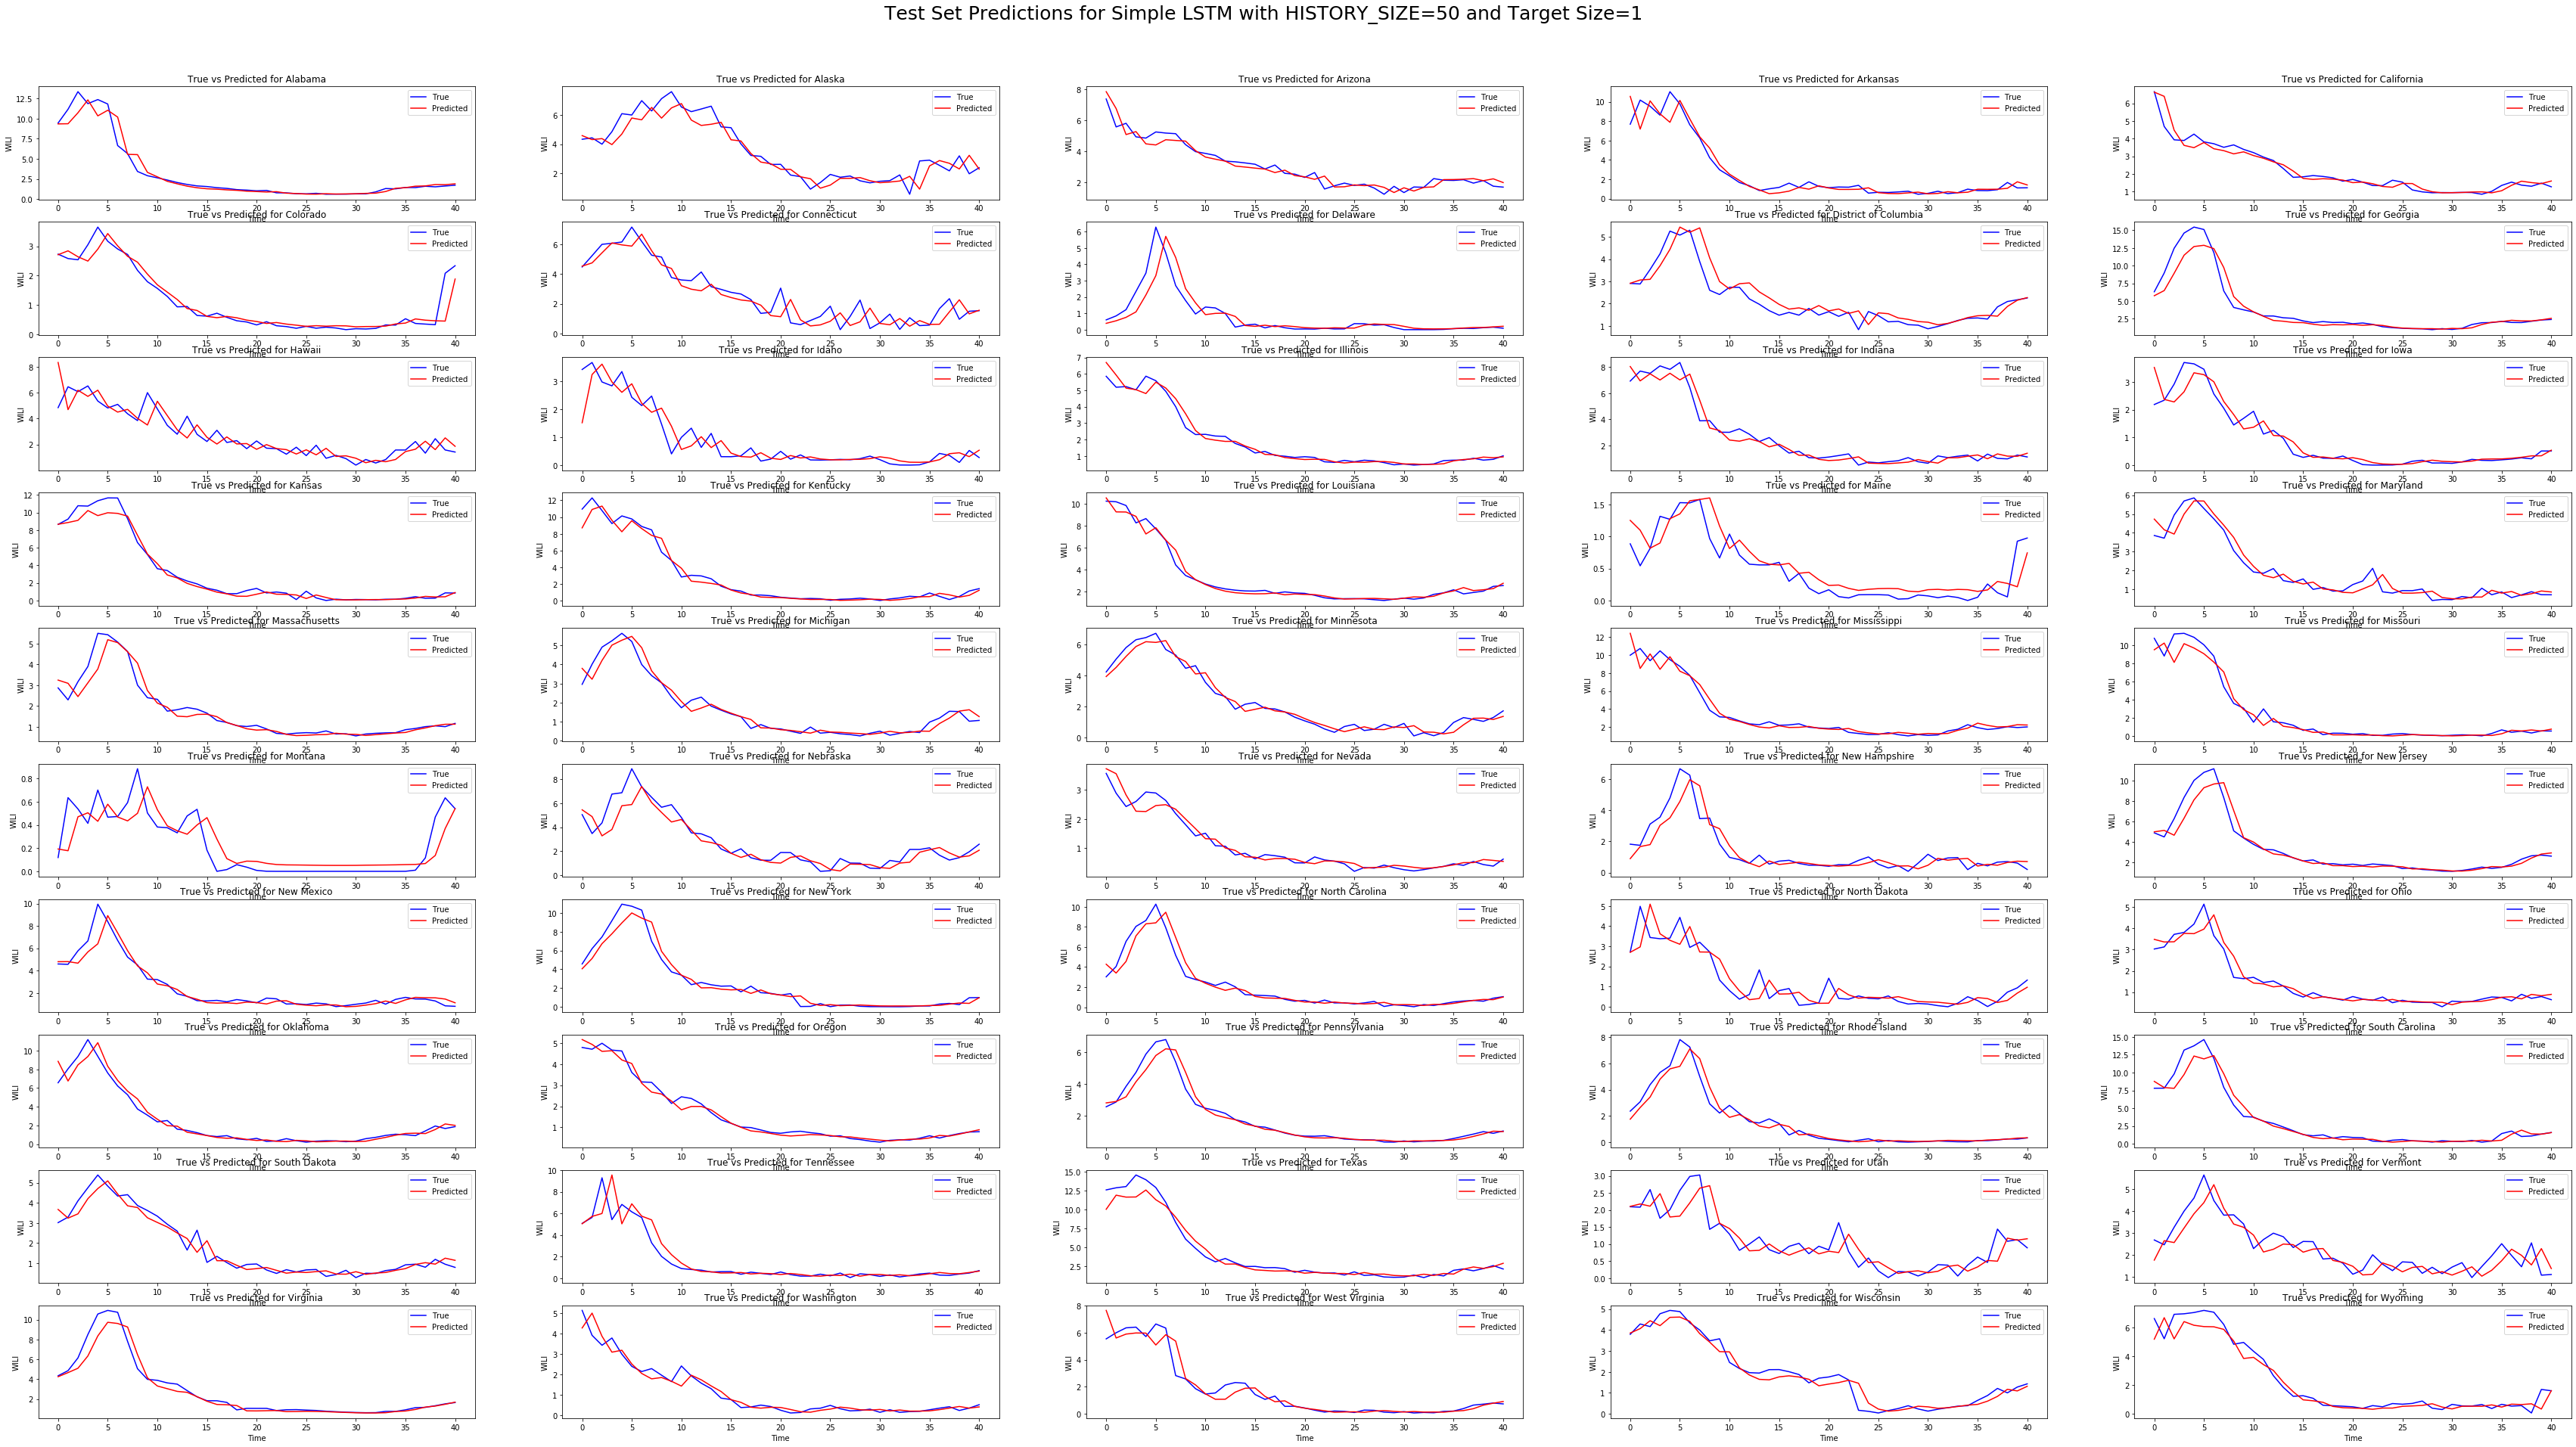

In [75]:
plot_test_preds_for_all_states(X_test, y_test, states_test, simple_lstm50, HISTORY_SIZE,
                               "Test Set Predictions for Simple LSTM with HISTORY_SIZE=50 and Target Size=1", scaler=sc)


As observed above, a simple LSTM model makes decent one-step predictions across states given a history of 50 weeks.

## Multi-step time series forecasting

The goal of this section is to predict next T weeks (e.g. 5 weeks) given H previous weeks (e.g. 50 weeks).

In this task we want to evaluate the model on how well it is able to predict the next couple of weeks. Hence we measure the RMSE for each of the next T steps of the multi-step prediction. This will allows us to see which models have better predictive accuracy at different lead times (e.g. +1 week vs +4 weeks).

### Creating data for multi-step predictions

Below, we adjust the training data to pairs (X,y), where X is a H-week history vector and y is T-future-weeks target vector.

In [77]:
HISTORY_SIZE = 25
TARGET_SIZE = 5

ds_train, ds_val, ds_test, data_dict_multi = time_series.prepare_data(X_scaled, 
                                             groups,
                                             history_size=HISTORY_SIZE, 
                                             target_size=TARGET_SIZE,
                                             batch_size = 64,                         
                                             test_size=0.2)

In [78]:
X_test = data_dict_multi['X_test']
y_test = data_dict_multi['y_test']
states_test = data_dict_multi['states_test']

In [79]:
X_test.shape

(2150, 25, 1)

In [80]:
y_test.shape

(2150, 5, 1)

## Simple LSTM with vector output 

#### History of 25 weeks to predict next 5 weeks


In [107]:
simple_lstm_multi = make_simple_lstm(history_length=HISTORY_SIZE, 
                                     target_length=TARGET_SIZE, 
                                     num_lstm_layers=3, 
                                     hidden_size=32, 
                                     pre_output_dense_size=32)

In [108]:
simple_lstm_multi.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 25, 32)            4352      
_________________________________________________________________
lstm_18 (LSTM)               (None, 25, 32)            8320      
_________________________________________________________________
lstm_19 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_12 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 165       
Total params: 22,213
Trainable params: 22,213
Non-trainable params: 0
_________________________________________________________________


In [100]:
simple_lstm_multi.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
269/269 [==============================] - 18s 67ms/step - loss: 0.4238 - val_loss: 0.0000e+00
Epoch 2/10
269/269 [==============================] - 15s 56ms/step - loss: 0.2605 - val_loss: 0.3720
Epoch 3/10
269/269 [==============================] - 15s 56ms/step - loss: 0.2440 - val_loss: 0.3713
Epoch 4/10
269/269 [==============================] - 15s 56ms/step - loss: 0.2426 - val_loss: 0.3634
Epoch 5/10
269/269 [==============================] - 15s 56ms/step - loss: 0.2398 - val_loss: 0.3456
Epoch 6/10
269/269 [==============================] - 15s 56ms/step - loss: 0.2389 - val_loss: 0.3512
Epoch 7/10
269/269 [==============================] - 15s 56ms/step - loss: 0.2349 - val_loss: 0.3362
Epoch 8/10
269/269 [==============================] - 15s 56ms/step - loss: 0.2320 - val_loss: 0.3492
Epoch 9/10
269/269 [==============================] - 15s 56ms/step - loss: 0.2317 - val_loss: 0.3445
Epoch 10/10
269/269 [==============================] - 15s 56ms/step - loss: 0

In [9]:
def evaluate_multiple_steps_preds(y_true, X, model, target_size, scaler):
    #calculate the rmse for each for each of the 
    #steps individualy (i.e. error for one week ahead, 2 weeks ahead and so on)
    
    predicted = model.predict(X).reshape(-1,target_size)
    y_true = y_true.reshape(-1,target_size)

    if scaler!=None:
        y_true = scaler.inverse_transform(y_true)
        predicted = scaler.inverse_transform(predicted)
    rmses = []
    for i in range(predicted.shape[1]):
        rmse_step = calculate_rmse(y_true[:,i], predicted[:,i])
        rmses.append(rmse_step)
    rmses = np.array(rmses)
    return rmses, rmses.mean()

In [101]:
evaluate_multiple_steps_preds(y_test, X_test, simple_lstm_multi, TARGET_SIZE, sc)


(array([0.8252872 , 1.19231529, 1.4705963 , 1.69746173, 1.88219183]),
 1.413570469519118)

In [96]:
results_multi = {}
results_multi['simple_lstm_5_weeks_preds'] = evaluate_multiple_steps_preds(y_test, X_test, simple_lstm_multi, TARGET_SIZE, sc)

In [97]:
results_multi

{'simple_lstm_5_weeks_preds': (array([0.83793841, 1.20691301, 1.46977541, 1.67940546, 1.85663041]),
  1.4101325413756942)}

In [8]:
def plot_multiple_steps_preds_for_state(X_test, y_test, states_test, model, target_size, state, scaler=None):
    #plot the preds for target_size weeks ahead skipping every target_size inputs 
    preds = model.predict(X_test[states_test==state])
    y = y_test[states_test==state]
    rmses, mean_rmse = evaluate_multiple_steps_preds(y, X_test[states_test==state], model, target_size, scaler)
    if scaler!=None:
        y = scaler.inverse_transform(y_test[states_test==state])
        preds = scaler.inverse_transform(preds)
    
    multiple_step_preds = preds[::target_size,:].flatten()
    y = y[::target_size, :].flatten()
    
    print(f"RMSES for each step = {rmses}, average = {mean_rmse}")
    
    plt.figure(figsize=(10,8))
    plt.plot(y, 'b-', label='True')
    plt.plot(multiple_step_preds, 'r-', label='Predicted')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('WILI')
    plt.title(f'True vs {target_size}-steps prediction for {state}')
    plt.show()

Below we are plotting the predictions of the model for 5 weeks into the future. We want to understand whether the model captures the pattern for the next weeks ahead. For this reason, we set the first point in time on the test set as $t$ and we predict the WILI rate for next 5 weeks from this point given a history of 25 weeks. We form the first piece of the red line by connecting the predictions for the next 5 weeks. Then we skip the next 5 weeks and we repeat the process for predicting the next 5 weeks by knowing all the information up to $t+5$ weeks, to get another line of 5-week predictions. Finally we connect all these lines to form the entire red line which shows how well the model predicted the trends 5 weeks ahead.

RMSES for each step = [0.87089709 1.45612704 1.79428004 2.13534701 2.34370364], average = 1.7200709654964328


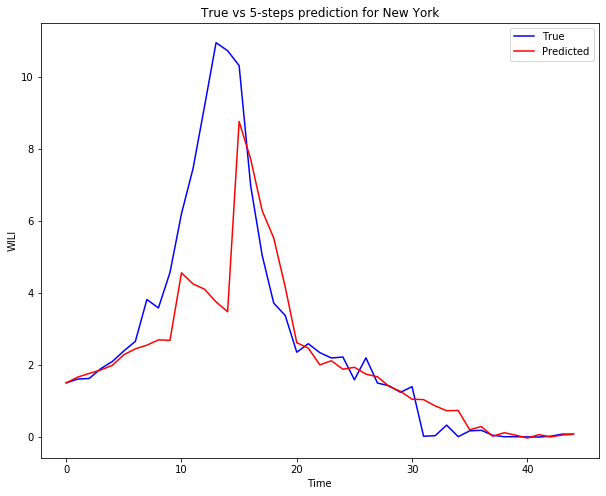

In [106]:
plot_multiple_steps_preds_for_state(X_test, y_test.reshape(-1,TARGET_SIZE), states_test, simple_lstm_multi, TARGET_SIZE, 'New York', sc)

#### History of 50 weeks to predict next 5 weeks


In [109]:
HISTORY_SIZE = 50
TARGET_SIZE = 5

ds_train, ds_val, ds_test, data_dict_multi = time_series.prepare_data(X_scaled, 
                                             groups,
                                             history_size=HISTORY_SIZE, 
                                             target_size=TARGET_SIZE,
                                             batch_size = 64,                         
                                             test_size=0.2)

In [110]:
X_test = data_dict_multi['X_test']
y_test = data_dict_multi['y_test']
states_test = data_dict_multi['states_test']

In [124]:
X_all = np.concatenate((data_dict_multi['X_train'],data_dict_multi['X_val'], data_dict_multi['X_test']))
y_all = np.concatenate((data_dict_multi['y_train'],data_dict_multi['y_val'], data_dict_multi['y_test']))
states_all = np.concatenate((data_dict_multi['states_train'],data_dict_multi['states_val'], data_dict_multi['states_test']))

In [111]:
simple_lstm_multi50 = make_simple_lstm(history_length=HISTORY_SIZE, 
                                     target_length=TARGET_SIZE, 
                                     num_lstm_layers=3, 
                                     hidden_size=32, 
                                     pre_output_dense_size=32)

In [112]:
simple_lstm_multi50.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
254/254 [==============================] - 44s 172ms/step - loss: 15.1993 - val_loss: 0.0000e+00
Epoch 2/10
254/254 [==============================] - 40s 157ms/step - loss: 0.6064 - val_loss: 0.7993
Epoch 3/10
254/254 [==============================] - 40s 158ms/step - loss: 0.3778 - val_loss: 0.3671
Epoch 4/10
254/254 [==============================] - 40s 157ms/step - loss: 0.2708 - val_loss: 0.3233
Epoch 5/10
254/254 [==============================] - 40s 158ms/step - loss: 0.2458 - val_loss: 0.2792
Epoch 6/10
254/254 [==============================] - 40s 158ms/step - loss: 0.2334 - val_loss: 0.3015
Epoch 7/10
254/254 [==============================] - 40s 157ms/step - loss: 0.2307 - val_loss: 0.2798
Epoch 8/10
254/254 [==============================] - 40s 157ms/step - loss: 0.2282 - val_loss: 0.2693
Epoch 9/10
254/254 [==============================] - 40s 158ms/step - loss: 0.2277 - val_loss: 0.2650
Epoch 10/10
254/254 [==============================] - 40s 157ms/ste

In [113]:
evaluate_multiple_steps_preds(y_test, X_test, simple_lstm_multi50, TARGET_SIZE, sc)


(array([0.77131417, 1.00053257, 1.21520033, 1.36353289, 1.42957368]),
 1.1560307270911383)

In [114]:
results_multi['simple_lstm50_5_weeks_preds'] = evaluate_multiple_steps_preds(y_test, X_test, simple_lstm_multi50, TARGET_SIZE, sc)

In [115]:
results_multi

{'simple_lstm_5_weeks_preds': (array([0.83793841, 1.20691301, 1.46977541, 1.67940546, 1.85663041]),
  1.4101325413756942),
 'simple_lstm50_5_weeks_preds': (array([0.77131417, 1.00053257, 1.21520033, 1.36353289, 1.42957368]),
  1.1560307270911383)}

Below we plot 5-step predictions on test set as well as on the whole time series for a given state.

RMSES for each step = [0.72458623 0.98311164 1.35867076 1.72625959 1.86722105], average = 1.3319698538424816


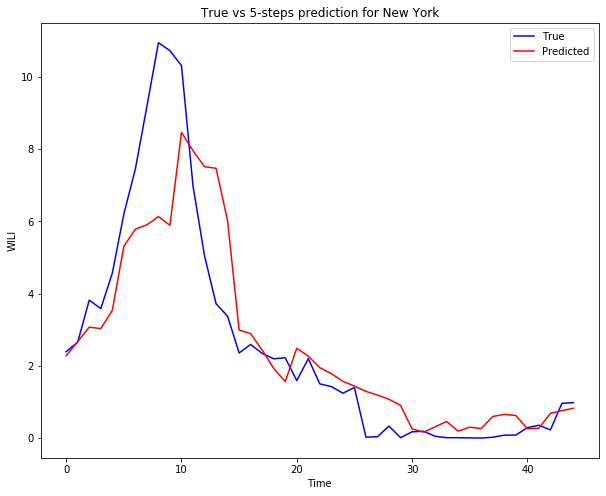

In [123]:
plot_multiple_steps_preds_for_state(X_test, y_test.reshape(-1,TARGET_SIZE), states_test, simple_lstm_multi50, TARGET_SIZE, 'New York', sc)


RMSES for each step = [0.55126297 0.7509124  0.90531866 1.01701707 1.11789905], average = 0.8684820317168235


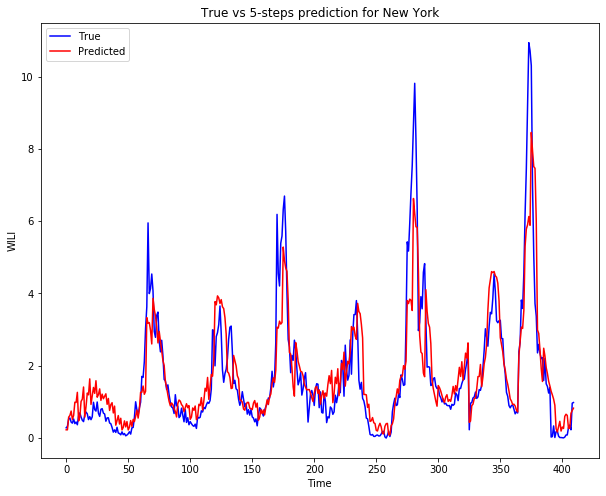

In [129]:
plot_multiple_steps_preds_for_state(X_all, y_all.reshape(-1,TARGET_SIZE), states_all, simple_lstm_multi50, TARGET_SIZE, 'New York', sc)


#### History of 50 weeks to predict next 10 weeks

In [131]:
HISTORY_SIZE = 50
TARGET_SIZE = 10

ds_train, ds_val, ds_test, data_dict_multi = time_series.prepare_data(X_scaled, 
                                             groups,
                                             history_size=HISTORY_SIZE, 
                                             target_size=TARGET_SIZE,
                                             batch_size = 64,                         
                                             test_size=0.2)

In [132]:
X_test = data_dict_multi['X_test']
y_test = data_dict_multi['y_test']
states_test = data_dict_multi['states_test']

In [133]:
X_all = np.concatenate((data_dict_multi['X_train'],data_dict_multi['X_val'], data_dict_multi['X_test']))
y_all = np.concatenate((data_dict_multi['y_train'],data_dict_multi['y_val'], data_dict_multi['y_test']))
states_all = np.concatenate((data_dict_multi['states_train'],data_dict_multi['states_val'], data_dict_multi['states_test']))

In [134]:
simple_lstm_multi50_10 = make_simple_lstm(history_length=HISTORY_SIZE, 
                                     target_length=TARGET_SIZE, 
                                     num_lstm_layers=3, 
                                     hidden_size=32, 
                                     pre_output_dense_size=32)

In [135]:
simple_lstm_multi50_10.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
250/250 [==============================] - 42s 170ms/step - loss: 0.6854 - val_loss: 0.0000e+00
Epoch 2/10
250/250 [==============================] - 39s 155ms/step - loss: 0.4098 - val_loss: 0.4281
Epoch 3/10
250/250 [==============================] - 39s 155ms/step - loss: 0.3481 - val_loss: 0.4394
Epoch 4/10
250/250 [==============================] - 39s 155ms/step - loss: 0.3212 - val_loss: 0.4144
Epoch 5/10
250/250 [==============================] - 39s 154ms/step - loss: 0.3089 - val_loss: 0.4089
Epoch 6/10
250/250 [==============================] - 39s 156ms/step - loss: 0.2977 - val_loss: 0.3444
Epoch 7/10
250/250 [==============================] - 39s 155ms/step - loss: 0.2912 - val_loss: 0.3786
Epoch 8/10
250/250 [==============================] - 39s 154ms/step - loss: 0.2834 - val_loss: 0.3598
Epoch 9/10
250/250 [==============================] - 39s 155ms/step - loss: 0.2778 - val_loss: 0.3229
Epoch 10/10
250/250 [==============================] - 39s 154ms/step

In [136]:
evaluate_multiple_steps_preds(y_test, X_test, simple_lstm_multi50_10, TARGET_SIZE, sc)


(array([0.85710313, 1.14499253, 1.35007836, 1.49691969, 1.64478866,
        1.70712876, 1.78206144, 1.78972858, 1.72764668, 1.71185824]),
 1.5212306073437072)

In [137]:
results_multi['simple_lstm50_10_weeks_preds'] = evaluate_multiple_steps_preds(y_test, X_test, simple_lstm_multi50_10, TARGET_SIZE, sc)


In [138]:
results_multi

{'simple_lstm_5_weeks_preds': (array([0.83793841, 1.20691301, 1.46977541, 1.67940546, 1.85663041]),
  1.4101325413756942),
 'simple_lstm50_5_weeks_preds': (array([0.77131417, 1.00053257, 1.21520033, 1.36353289, 1.42957368]),
  1.1560307270911383),
 'simple_lstm50_10_weeks_preds': (array([0.85710313, 1.14499253, 1.35007836, 1.49691969, 1.64478866,
         1.70712876, 1.78206144, 1.78972858, 1.72764668, 1.71185824]),
  1.5212306073437072)}

RMSES for each step = [0.61006053 0.79841125 0.93721983 1.01716266 1.10075661 1.12688263
 1.16834233 1.21481316 1.23579018 1.26473561], average = 1.0474174796524793


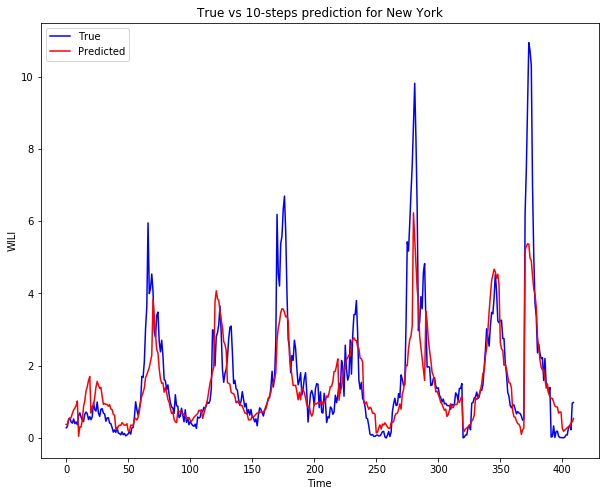

In [139]:
plot_multiple_steps_preds_for_state(X_all, y_all.reshape(-1,TARGET_SIZE), states_all, simple_lstm_multi50_10, TARGET_SIZE, 'New York', sc)


## Seq2Seq models for multi-step predictions


### Simple encoder-decoder model

First we will try to build a model for 5-week predictions and then we will test performance for 10-week predictions.

#### History of 50 weeks to predict next 5 weeks


In [10]:
HISTORY_SIZE = 50
TARGET_SIZE = 5

ds_train, ds_val, ds_test, data_dict_multi = time_series.prepare_data(X_scaled, 
                                             groups,
                                             history_size=HISTORY_SIZE, 
                                             target_size=TARGET_SIZE,
                                             batch_size = 64,                         
                                             test_size=0.2,
                                             teacher_forcing=True                       
                                             )

In [21]:
X_test = data_dict_multi['X_test']
y_test = data_dict_multi['y_test']
states_test = data_dict_multi['states_test']

In [12]:
seq2seq_model = models.Seq2Seq(history_length=HISTORY_SIZE,
                               target_length=TARGET_SIZE,
                               hidden_size=32,
                               num_encoder_layers=3,
                               num_decoder_layers=3,
                               pre_output_dense_size=16
                               )

In [13]:
seq2seq_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 1)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
encoder (LSTM)                  [(None, 32), (None,  4352        input_1[0][0]                    
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, None, 32), ( 4352        input_2[0][0]                    
                                                                 encoder[0][1]                

In [14]:
seq2seq_model.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
254/254 [==============================] - 10s 41ms/step - loss: 0.1780 - val_loss: 0.0000e+00
Epoch 2/10
254/254 [==============================] - 3s 13ms/step - loss: 0.1035 - val_loss: 0.1048
Epoch 3/10
254/254 [==============================] - 3s 13ms/step - loss: 0.1005 - val_loss: 0.1069
Epoch 4/10
254/254 [==============================] - 3s 13ms/step - loss: 0.0994 - val_loss: 0.1032
Epoch 5/10
254/254 [==============================] - 3s 13ms/step - loss: 0.0979 - val_loss: 0.0999
Epoch 6/10
254/254 [==============================] - 3s 13ms/step - loss: 0.0970 - val_loss: 0.1021
Epoch 7/10
254/254 [==============================] - 3s 13ms/step - loss: 0.0963 - val_loss: 0.1049
Epoch 8/10
254/254 [==============================] - 3s 13ms/step - loss: 0.0956 - val_loss: 0.1038
Epoch 9/10
254/254 [==============================] - 3s 13ms/step - loss: 0.0947 - val_loss: 0.1109
Epoch 10/10
254/254 [==============================] - 3s 13ms/step - loss: 0.0943 - v

In [39]:
def predict_seq2seq(X, model, target_size):
    preds = []
    for i in range(X.shape[0]):
        pred = model.decode_sequence(X[i], target_size).reshape((-1, target_size))
        preds.extend(pred)
    preds = np.stack(preds, axis=0)
    return preds

In [40]:
def evaluate_multiple_steps_preds_seq2seq(y_true, X, model, target_size, scaler):
    #calculate the rmse for each for each of the 
    #steps individualy (i.e. error for one week ahead, 2 weeks ahead and so on)
    
    predicted = predict_seq2seq(X, model, target_size)
    y_true = y_true.reshape(-1,target_size)

    if scaler!=None:
        y_true = scaler.inverse_transform(y_true)
        predicted = scaler.inverse_transform(predicted)
    rmses = []
    for i in range(predicted.shape[1]):
        rmse_step = calculate_rmse(y_true[:,i], predicted[:,i])
        rmses.append(rmse_step)
    rmses = np.array(rmses)
    return rmses, rmses.mean()

In [44]:
evaluate_multiple_steps_preds_seq2seq(y_test, X_test, seq2seq_model, TARGET_SIZE, sc)


(array([0.74731831, 1.06121422, 1.24030728, 1.3130552 , 1.31596727]),
 1.1355724555609203)

#### History of 50 weeks to predict next 10 weeks


In [45]:
HISTORY_SIZE = 50
TARGET_SIZE = 10

ds_train, ds_val, ds_test, data_dict_multi = time_series.prepare_data(X_scaled, 
                                             groups,
                                             history_size=HISTORY_SIZE, 
                                             target_size=TARGET_SIZE,
                                             batch_size = 64,                         
                                             test_size=0.2,
                                             teacher_forcing=True                       
                                             )

In [48]:
X_test = data_dict_multi['X_test']
y_test = data_dict_multi['y_test']
states_test = data_dict_multi['states_test']

In [46]:
seq2seq_model_10steps = models.Seq2Seq(history_length=HISTORY_SIZE,
                               target_length=TARGET_SIZE,
                               hidden_size=32,
                               num_encoder_layers=3,
                               num_decoder_layers=3,
                               pre_output_dense_size=16
                               )

In [47]:
seq2seq_model_10steps.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
250/250 [==============================] - 8s 33ms/step - loss: 0.2315 - val_loss: 0.0000e+00
Epoch 2/10
250/250 [==============================] - 4s 14ms/step - loss: 0.1076 - val_loss: 0.1117
Epoch 3/10
250/250 [==============================] - 4s 14ms/step - loss: 0.1037 - val_loss: 0.1035
Epoch 4/10
250/250 [==============================] - 4s 14ms/step - loss: 0.0998 - val_loss: 0.1050
Epoch 5/10
250/250 [==============================] - 4s 14ms/step - loss: 0.0975 - val_loss: 0.1102
Epoch 6/10
250/250 [==============================] - 4s 14ms/step - loss: 0.0961 - val_loss: 0.1089
Epoch 7/10
250/250 [==============================] - 4s 14ms/step - loss: 0.0948 - val_loss: 0.1080
Epoch 8/10
250/250 [==============================] - 4s 14ms/step - loss: 0.0948 - val_loss: 0.1115
Epoch 9/10
250/250 [==============================] - 4s 14ms/step - loss: 0.0936 - val_loss: 0.1094
Epoch 10/10
250/250 [==============================] - 4s 14ms/step - loss: 0.0938 - va

In [49]:
evaluate_multiple_steps_preds_seq2seq(y_test, X_test, seq2seq_model, TARGET_SIZE, sc)


(array([0.75989268, 1.08040481, 1.274638  , 1.40612279, 1.50267847,
        1.5845602 , 1.65058573, 1.66479728, 1.64529348, 1.64843005]),
 1.421740350677126)